# IEOR4525 - Spam Filter Project

#### **Name:**  Xiuqi Fan

#### **Uni:**   `xf2207` 

## Preparation

Import libraries needed.

In [1]:
import string
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import codecs
from email.message import EmailMessage
from email import message_from_file
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import BernoulliNB,MultinomialNB,GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from scipy.sparse import hstack

import sys 
import warnings
sys.path.append("../..")
warnings.filterwarnings('ignore')

#from E4525_ML import text

## 3. Data Pre-processing

### 3.1 DataTable

Create a dataframe DataTable including the features: `email_id`, `parts`, `attachments`, `html`, `subject`, `body`, `links`.
<html>
    <p>Useful links: 
        <a href='https://docs.python.org/3/library/email.message.html'>email.message</a>, 
        <a href='https://www.crummy.com/software/BeautifulSoup/bs4/doc/'>BeautifulSoup</a>
    </p>
</html>

In [2]:
path0 = r'../projects/trec05p-1/data' 

def Create_columns(path0):
    
    files = os.listdir(path0)
    
    email_id = []
    parts = []
    attachments = []
    html = []
    subject = []
    body = []
    links = []

    for file in files: 
        id_1 = file
        path1 = path0 +'/'+file
        #print(path1)

        if os.path.isdir(path1):
            email_file = os.listdir(path1)

            for file in email_file:
                # 1.id
                id_ = id_1 +'/'+ file
                path_email = path1+'/'+file
                #print(path_email)

                with codecs.open(path_email, 'r', encoding='utf-8',errors='ignore') as fp:
                    msg = message_from_file(fp)
                    # 5.subjects
                    subj = msg.get('Subject')
                    
                    # 2,3,4,6,7 parts/attachments/html/body/links
                    body_n = ''
                    
                    if msg.is_multipart():
                        part_n = 0
                        atch_n = 0
                        html_n = 0
                        link_n = 0

                        for part in msg.walk():
                            part_type = part.get_content_type()
                            if 'Content-Disposition' in part.keys():
                                atch_n += 1
                                
                            # skip any text/plain (txt) attachments
                            cdispo = str(part.get('Content-Disposition'))
                            if part_type == 'text/plain' and 'attachment' not in cdispo:
                                body_n += part.get_payload()  # decode

                            if part_type =='text/html':
                                html_n = 1
                                html_doc = part.get_payload()
                                soup = BeautifulSoup(html_doc, 'html.parser')
                                tag_list = soup.find_all('a')
                                link_n += len(tag_list)
                                for a in tag_list:
                                    body_n += a.text
                            part_n += 1    

                    else:
                        part_n = 0
                        atch_n = 0
                        html_n = 0
                        link_n = 0
                        body_n = msg.get_payload(decode=True)
                
                email_id.append(id_)
                parts.append(part_n)
                attachments.append(atch_n)
                html.append(html_n)
                subject.append(subj)
                body.append(body_n)
                links.append(link_n)
    return email_id, parts, attachments, html, subject, body, links

email_id, parts, attachments, html, subject, body, links = Create_columns(path0)

In [3]:
DataTable = pd.DataFrame(columns=['email_id','parts','attachments','html','subject','body','links'])
DataTable['email_id'] = email_id
DataTable['parts'] = parts
DataTable['attachments'] = attachments 
DataTable['html'] = html
DataTable['subject'] = subject
DataTable['body'] = body 
DataTable['links'] = links

print('DataTable.shape:',DataTable.shape)
DataTable.head()

DataTable.shape: (92189, 7)


,email_id,parts,attachments,html,subject,body,links
0,135/135,0,0,0,FW: Enron Kids announcement,"b""The attached request was to run for 3 weeks....",0
1,135/132,0,0,0,"Morning Market View for November 19, 2001","b'Charles Schwab & Co., Inc.\nEmail Alert\n\nM...",0
2,135/104,0,0,0,Enron Mentions - 11/17/01 - 11/18/01,b'They left behind big piles of money\nHouston...,0
3,135/103,0,0,0,FW: Mr. Abby **sensitive,"b""\n\n\n ...",0
4,135/168,0,0,0,H0t penny play On strOng breakOut,"b""Now that Oil and Gas has entered a long-term...",0


### 3.2 Full

Read the label file: full/index

In [4]:
full_path = r'../projects/trec05p-1/full/index'
full = pd.read_csv(full_path,delimiter = ' ',header = None)
full.rename(columns={0:'label',1:'email_file_path'},inplace = True)
print(full.shape)
full.head()

(92189, 2)


,label,email_file_path
0,ham,../data/000/000
1,ham,../data/000/001
2,ham,../data/000/002
3,ham,../data/000/003
4,ham,../data/000/004


### 3.3 DataFrame

Join DataTable and Full to get the labels: y = `ham` or y = `spam`.

Save the resulting DataFrame into emails 05.csv.

In [5]:
def get_email_id(x):
    return x[8:]
full['email_id'] = full['email_file_path'].apply(get_email_id)
DataFrame = DataTable.merge(full, on='email_id').iloc[:,:-1]
DataFrame.to_csv('emails_05.csv')
DataFrame.head()

,email_id,parts,attachments,html,subject,body,links,label
0,135/135,0,0,0,FW: Enron Kids announcement,"b""The attached request was to run for 3 weeks....",0,ham
1,135/132,0,0,0,"Morning Market View for November 19, 2001","b'Charles Schwab & Co., Inc.\nEmail Alert\n\nM...",0,ham
2,135/104,0,0,0,Enron Mentions - 11/17/01 - 11/18/01,b'They left behind big piles of money\nHouston...,0,ham
3,135/103,0,0,0,FW: Mr. Abby **sensitive,"b""\n\n\n ...",0,ham
4,135/168,0,0,0,H0t penny play On strOng breakOut,"b""Now that Oil and Gas has entered a long-term...",0,spam


### 3.4 Train/Test Split

Split the email data into 15% test set and 85% training set.

In [6]:
x_train, x_test, label_train, label_test = train_test_split(DataFrame.iloc[:,:7], DataFrame['label'], test_size=0.15)
y_train = (label_train=='spam')*1
y_test = (label_test=='spam')*1
print('Training: ',x_train.shape,y_train.shape)
print('Testing: ',x_test.shape,y_test.shape,)

Training:  (78360, 7) (78360,)
Testing:  (13829, 7) (13829,)


## 4. Naive Bayes Spam Detection

Build Naive Bayes models using different types of information to investigate how to best predict spam.

Firstly, create a function using 5-Fold cross-validation to output `AUC` (ROC area under the curve) for the model.

In [7]:
# This function only uses training set. It splits it into training+validation
# X: features, Y:labels
def cv_5folds(model, X, Y):     
    
    kf = KFold(5, shuffle=True)
    folds = list(kf.split(X))
    
    kfolds = len(folds)
    AUC = np.empty(kfolds)
    
    for idx in range(kfolds):
        train,validation = folds[idx]
        #print('idx',idx,train,validation)
        X_train = X[train]
        y_train = Y[train]
        model.fit(X_train,y_train)
        X_validation = X[validation]
        y_validation = Y[validation]
        y_preds = model.predict_proba(X_validation)[:,1]    # prediction probability:  True
        fpr, tpr, threshold = metrics.roc_curve(y_validation,y_preds)
        auc = metrics.auc(fpr,tpr)
        AUC[idx] = auc
        #print('idx',idx,auc)        
    return AUC.mean()

### 4.1 Naive Bayes: Structural Information Model

`multipart` = 1 if message is multi-part, 0 otherwise.

`html` = 1 if message contains a text/html part, 0 otherwise. 

`links` = 1 if message body contains hyperlinks, 0 otherwise. 

`attachments` = 1 if message contains attachments, 0 otherwise.

In [8]:
x_train_1 = pd.DataFrame(columns=['multipart','html','links','attachments','label'])

x_train_1['multipart'] = (x_train['parts']!=0)*1
x_train_1['html'] = x_train['html'].values
x_train_1['links'] = (x_train['links']!=0)*1
x_train_1['attachments'] = (x_train['attachments']!=0)*1
x_train_1['label'] = y_train.values

print(x_train_1.shape)

(78360, 5)


Train a Naive Bayes model, with smoothing parameter alpha=1.

In [9]:
model1 = BernoulliNB(alpha=1)
AUC1 = cv_5folds(model1, x_train_1.iloc[:,:-1].values, x_train_1.iloc[:,-1].values)

print('The 5-Fold CV AUC for Structural Information Model is:')
print(AUC1)

The 5-Fold CV AUC for Structural Information Model is:
0.7030921674346938


### 4.2 Naive Bayes: Subject Model

Train a multinomial Naive-Bayes model on the `bag-of-word` representation of the `message subject`.

In [10]:
x_train_2 = x_train['subject']
y_train_2 = y_train.values

def process_None(x):
    if x == None:
        return ''
    else:
        return x
x_train_2 = np.array(x_train_2.apply(process_None))

In [11]:
Count_vectorizer = CountVectorizer(input='content')
Set_vectorizer   = CountVectorizer(input='content',binary=True)
Tfidf_vectorizer = TfidfVectorizer(input='content')

s_count_train = Count_vectorizer.fit_transform(x_train_2)
s_set_train   = Set_vectorizer.fit_transform(x_train_2)
s_tfidf_train = Tfidf_vectorizer.fit_transform(x_train_2)

In [12]:
model2 = MultinomialNB(alpha=1)
AUC2_count = cv_5folds(model2, s_count_train, y_train_2)
AUC2_set   = cv_5folds(model2, s_set_train,   y_train_2)
AUC2_tfidf = cv_5folds(model2, s_tfidf_train, y_train_2)

print('The 5-Fold CV AUC for Subject Model is:')
print('Count:  ',AUC2_count)
print('Set:    ',AUC2_set)
print('Tf-Idf: ',AUC2_tfidf)

The 5-Fold CV AUC for Subject Model is:
Count:   0.9768599351431136
Set:     0.9769810011687673
Tf-Idf:  0.9771840505017119


### 4.3 Naive Bayes: Message Body Model

Train a multinomial Naive-Bayes model on the `bag-of-word` representation of the `message body`.

In [13]:
x_train_3 = x_train['body']
y_train_3 = y_train.values

def process_NoneNonASCII(x):
    if x == None:
        return ''
    else:
        try:
            return x.decode('utf-8','ignore').strip()
        except:
            return x.encode('utf-8').strip()
    
x_train_3 = np.array(x_train_3.apply(process_NoneNonASCII))

In [14]:
Count_vectorizer = CountVectorizer(input='content')
Set_vectorizer   = CountVectorizer(input='content',binary=True)
Tfidf_vectorizer = TfidfVectorizer(input='content')

b_count_train = Count_vectorizer.fit_transform(x_train_3)
b_set_train   = Set_vectorizer.fit_transform(x_train_3)
b_tfidf_train = Tfidf_vectorizer.fit_transform(x_train_3)

In [15]:
model3 = MultinomialNB(alpha=1)
AUC3_count = cv_5folds(model3, b_count_train, y_train_3)
AUC3_set   = cv_5folds(model3, b_set_train,   y_train_3)
AUC3_tfidf = cv_5folds(model3, b_tfidf_train, y_train_3)

print('The 5-Fold CV AUC for Message Body Model is:')
print('Count:  ',AUC3_count)
print('Set:    ',AUC3_set)
print('Tf-Idf: ',AUC3_tfidf)

The 5-Fold CV AUC for Message Body Model is:
Count:   0.984057079781431
Set:     0.9869672763043255
Tf-Idf:  0.9902631576951408


### 4.4 Naive Bayes: My Own Model 

Use the real values of `parts`, `attachments`, `links` instead of their binary values, together with a new value `sub` representing whether the email has a meaningful subject or not. `sub` equals to the ratio of the number of meaningful words to the total number of words in the subject.
And I use a Gaussian Naive Bayes here.

In [16]:
def process_text(corpus,stopwords): 
    porter_stemmer = PorterStemmer()
    text_str = " ".join(corpus).replace("\n"," ").lower()
    stem_list = word_tokenize(text_str)
    stoplist = set(stopwords.words("english"))
    used_list = [token for token in stem_list if token not in stoplist]
    return used_list

word_list = process_text(x_train_2,stopwords)
word_list = [i for i in set(word_list)]
word_list.sort()
for word in word_list:
    if len(word) >=10:
        word_list.pop(word_list.index(word))
word_list = word_list[word_list.index('aa'):word_list.index('xbox')]

def get_sub(x):
    if x == None:
        return 0
    else:
        x_words = x_train_2[0].split(' ')
        a = 0
        for i in x_words:
            if x.lower() in word_list:
                a+=1
        return a/len(x_words)

x_train_4 = pd.DataFrame(columns=['parts','html','links','attachments','sub','label'])

x_train_4['parts'] = x_train['parts']
x_train_4['html'] = x_train['html']
x_train_4['links'] = x_train['links']
x_train_4['attachments'] = x_train['attachments']
x_train_4['sub'] = x_train['subject'].apply(get_sub)
x_train_4['label'] = y_train.values

print(x_train_4.shape)

(78360, 6)


In [17]:
model4 = GaussianNB()
AUC4 = cv_5folds(model4, x_train_4.iloc[:,:-1].values, x_train_4['label'].values)

print('The 5-Fold CV AUC for My Own Model is:')
print(AUC4)

The 5-Fold CV AUC for My Own Model is:
0.7087621715484465


### 4.5 Naive Bayes: Combined Model

Build a Naive-Bayes model that combines the `structural` information, `subject` information and `message body` information.

And because `Tf-Idf` performs best in the `bag-of-words` model, so I'll use Tf-Idf feature.

So here I fit the previous 3 models and consider the predicted probabilities of them together to get the prediction of this combined model.

In [18]:
# This function only uses training set. It splits it into training+validation
# X: features, Y:labels
def combined_cv_5folds(model1,model2,model3, X1,X2,X3, Y):     
    
    kf = KFold(5, shuffle=True)
    folds = list(kf.split(X1))
    
    kfolds = len(folds)
    AUC = np.empty(kfolds)
    
    for idx in range(kfolds):
        train,validation = folds[idx]
        #print('idx',idx,train,validation)
        X1_train = X1[train]
        X2_train = X2[train]
        X3_train = X3[train]
        y_train = Y[train]
        X1_validation = X1[validation]
        X2_validation = X2[validation]
        X3_validation = X3[validation]
        y_validation = Y[validation]
        
        model1.fit(X1_train,y_train)
        model2.fit(X2_train,y_train)
        model3.fit(X3_train,y_train)
        
        y1_preds = model1.predict_proba(X1_validation)[:,1]    # prediction probability:  True
        y2_preds = model2.predict_proba(X2_validation)[:,1]  
        y3_preds = model3.predict_proba(X3_validation)[:,1] 
        y_preds = (y1_preds/3)+(y2_preds/3)+(y3_preds/3)
        
        fpr, tpr, threshold = metrics.roc_curve(y_validation,y_preds)
        auc = metrics.auc(fpr,tpr)
        AUC[idx] = auc
        #print('idx',idx,auc)        
    return AUC.mean()

In [19]:
AUC5 = combined_cv_5folds(model1,model2,model3, 
                          x_train_1.iloc[:,:-1].values, s_tfidf_train, b_tfidf_train, y_train.values)

print('The 5-Fold CV AUC for the Combined Model is:')
print(AUC5)

The 5-Fold CV AUC for the Combined Model is:
0.9970879983098323


## 5. Analyze Best Model

### 5.1 Best Model Selection

Using Area under the curve as a selection criteria, and 5-Fold cross validation, select the best of the 5 models I have trained before.

In [20]:
print('The AUCs of the 5 models are:')
print('Structural Information Model: ',AUC1)
print('My Own Model:                 ',AUC4)
print('Subject Model:                ',AUC2_tfidf)
print('Message Body Model:           ',AUC3_tfidf)
print('Combined Model:               ',AUC5)
print('So the Combined (Ensemble) Model is the best model here.')

The AUCs of the 5 models are:
Structural Information Model:  0.7034838800901629
My Own Model:                  0.7087621715484465
Subject Model:                 0.977056963683118
Message Body Model:            0.9902631576951408
Combined Model:                0.9970879983098323
So the Combined (Ensemble) Model is the best model here.


#### 5.1-1 AUC on Test Set
Retrain the best model using all the training data. Report the accuracy and AUC using the test set data I set aside before.

In [21]:
def best_model_prediction(x_train, y_train, x_test, y_test=None):
    # construct training and testing features for model 1
    x1_train = pd.DataFrame(columns=['multipart','html','links','attachments'])
    x1_train['multipart'] = (x_train['parts']!=0)*1
    x1_train['html'] = x_train['html'].values
    x1_train['links'] = (x_train['links']!=0)*1
    x1_train['attachments'] = (x_train['attachments']!=0)*1
    x1_train = x1_train.values
    x1_test = pd.DataFrame(columns=['multipart','html','links','attachments'])
    x1_test['multipart'] = (x_test['parts']!=0)*1
    x1_test['html'] = x_test['html'].values
    x1_test['links'] = (x_test['links']!=0)*1
    x1_test['attachments'] = (x_test['attachments']!=0)*1
    x1_test = x1_test.values
    # construct training and testing features for model 2
    x2_train = np.array(x_train['subject'].apply(process_None))
    x2_train = Tfidf_vectorizer.fit_transform(x2_train)
    x2_test = np.array(x_test['subject'].apply(process_None))
    x2_test = Tfidf_vectorizer.transform(x2_test)
    # construct training and testing features for model 3
    x3_train = np.array(x_train['body'].apply(process_NoneNonASCII))
    x3_train = Tfidf_vectorizer.fit_transform(x3_train)
    x3_test = np.array(x_test['body'].apply(process_NoneNonASCII))
    x3_test = Tfidf_vectorizer.transform(x3_test)
    # fit the model
    model1 = BernoulliNB(alpha=1)
    model1.fit(x1_train,y_train)
    model2 = MultinomialNB(alpha=1)
    model2.fit(x2_train,y_train)
    model3 = MultinomialNB(alpha=1)
    model3.fit(x3_train,y_train)
    # predict
    y1_preds = model1.predict_proba(x1_test)[:,1] 
    y2_preds = model2.predict_proba(x2_test)[:,1]  
    y3_preds = model3.predict_proba(x3_test)[:,1] 
    y_preds = (y1_preds/3)+(y2_preds/3)+(y3_preds/3)    
    return y_preds,y1_preds,y2_preds,y3_preds

y_preds,y1_preds,y2_preds,y3_preds = best_model_prediction(x_train, y_train.values, x_test, y_test)

In [22]:
fpr,  tpr,  threshold  = metrics.roc_curve(y_test,y_preds)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test,y1_preds)
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test,y2_preds)
fpr3, tpr3, threshold3 = metrics.roc_curve(y_test,y3_preds)
auc = metrics.auc(fpr,tpr)
y_hat = (y_preds>0.5)*1

print('Using best model on the test set:')
print('Accuracy: ',np.mean(y_hat==y_test))
print('AUC:      ',auc)

Using best model on the test set:
Accuracy:  0.9748354906356208
AUC:       0.9965741176480659


#### 5.1-2 AUC on Test Set
Plot the ROC curve (estimated using the test set data) for all the models I have considered. 

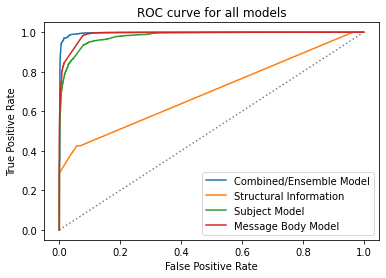

In [23]:
dots = np.arange(0,1,0.01)
plt.plot(dots,dots, linestyle='dotted', color='grey')
plt.plot(fpr, tpr,  label='Combined/Ensemble Model')
plt.plot(fpr1,tpr1, label='Structural Information')
plt.plot(fpr2,tpr2, label='Subject Model')
plt.plot(fpr3,tpr3, label='Message Body Model')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.title('ROC curve for all models')
plt.show()

**Question**:  If you wanted to block no more than 1% of all real (ham) email, what percentage of spam would the classifier be able to detect? What if you wanted to block no more than 0.2% percent?

which means:
1. fpr <= 1%, recall = ? recall = TP/(TP+FN) = tpr 

2. fpr <= 0.2%, recall = ?

In [24]:
print("{0:.00%}".format(tpr[np.argmin(abs(fpr-0.01))]), 'of spam would the classifier be able to detect if fpr<=1%')
print("{0:.0%}".format(tpr[np.argmin(abs(fpr-0.002))]), 'of spam would the classifier be able to detect if fpr<=0.2%')

95% of spam would the classifier be able to detect if fpr<=1%
79% of spam would the classifier be able to detect if fpr<=0.2%


## 6. TREC 2006 Analysis

### 6.1 TREC 2006 Data Pre-processing
This corpus has the same format as the TREC 2005 data set so I can re-use the pre-processing function before. 

In [25]:
path = r'../projects/trec06p/data' 
email_id, parts, attachments, html, subject, body, links = Create_columns(path)

In [26]:
DataTable06 = pd.DataFrame(columns=['email_id','parts','attachments','html','subject','body','links'])
DataTable06['email_id'] = email_id
DataTable06['parts'] = parts
DataTable06['attachments'] = attachments 
DataTable06['html'] = html
DataTable06['subject'] = subject
DataTable06['body'] = body 
DataTable06['links'] = links

print('DataTable06.shape:',DataTable06.shape)

DataTable06.shape: (37822, 7)


In [27]:
full_path = r'../projects/trec06p/full/index'
full06 = pd.read_csv(full_path,delimiter = ' ',header = None)
full06.rename(columns={0:'label',1:'email_file_path'},inplace = True)
print(full06.shape)

(37822, 2)


In [28]:
full06['email_id'] = full06['email_file_path'].apply(get_email_id)
DataFrame06 = DataTable06.merge(full06, on='email_id').iloc[:,:-1]
DataFrame06.to_csv('emails_06.csv')
DataFrame06.head()

,email_id,parts,attachments,html,subject,body,links,label
0,104/135,0,0,0,$B%9%+%&%H%a!<%k!!%Q!<%H(B2,"b'\x1b$B@hF|=w@-2q0wMM$+$i!""$""$J$?$K%9%+%&%H%a...",0,spam
1,104/132,0,0,0,"Dear Sir, i am interested in it","b'\n\n\n<html>\n<head>\n<meta http-equiv=""Cont...",0,spam
2,104/104,3,0,1,Hear to what our Med Customer says,%TXT_ADD\nMore Info Here,1,spam
3,104/103,0,0,0,Re: permission to archive,"b'Dearest Melanie,\n\nPermission granted, suck...",0,ham
4,104/168,0,0,0,is it possible Rebekah?\n,"b'\nED Choice, your best choice for ED drugs\n...",0,spam


### 6.2 Performance Analysis
Without re-training the models, estimate, using the test data, the accuracy, area under the curve, and plot the ROC curve for each one of the models I have considered before.

In [29]:
x_test06 = DataFrame06.iloc[:,:-1]
y_test06 = (DataFrame06['label']=='spam')*1
print('TRECT 2006 Testing:  ',x_test06.shape,  y_test06.shape,)

TRECT 2006 Testing:   (37822, 7) (37822,)


In [30]:
y_preds,y1_preds,y2_preds,y3_preds = best_model_prediction(x_train, y_train.values, x_test06, y_test06)

In [31]:
fpr,  tpr,  threshold  = metrics.roc_curve(y_test06,y_preds)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_test06,y1_preds)
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test06,y2_preds)
fpr3, tpr3, threshold3 = metrics.roc_curve(y_test06,y3_preds)
auc = metrics.auc(fpr,tpr)
y_hat = (y_preds>0.5)*1

print('Using best model on the TREC 2006 test set:')
print('Accuracy: ',np.mean(y_hat==y_test06))
print('AUC:      ',auc)

Using best model on the TREC 2006 test set:
Accuracy:  0.922267463381101
AUC:       0.9699742955777536


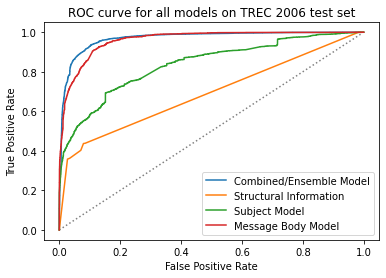

In [32]:
dots = np.arange(0,1,0.01)
plt.plot(dots,dots, linestyle='dotted', color='grey')
plt.plot(fpr, tpr,  label='Combined/Ensemble Model')
plt.plot(fpr1,tpr1, label='Structural Information')
plt.plot(fpr2,tpr2, label='Subject Model')
plt.plot(fpr3,tpr3, label='Message Body Model')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='best')
plt.title('ROC curve for all models on TREC 2006 test set')
plt.show()

### 6.3 Discussion
1. The best model (ensemble) performs very well in the TREC 2005 test set with an accuracy of 0.97 and an AUC of 0.99. But the performance decreased obviously when the trained model was applied to TREC 2006 test set, the accuracy is only around 0.9. Especially for the model 1,2,3, the AUC declined significantly. The reason might be that the data has different distributions.
2. I think the first reason is that, these additional marks made by the users could help to improve the model, such as adding features to the model or add penalty on some features. Another reason is this can help the model be customized, different users might have different preferences on the emails. For example, some might think promotion emails are spam but some might not. So this could customize the loss function of the models so that the spam software can give different levels of warnings based on the users' preferences.
3. The comments are at the end of section 7 as below.

## 7. Further Work
Try to apply other machine learning algorithms on this problem.

### 7.1 Gradient Boosted Trees
In this section, I will used GBDT to train a spam filter model. I will use the message body model with tfidf as the text feature bacause it's the feature with the best performance. Also, I use grid search to find the best n_estimators and max_depth.

In [14]:
# Use grid search to choose the best parameter

def GB_prediction(x_train, y_train, x_test, e, d, y_test=None,):
    # construct training and testing features for model 2
    train = np.array(x_train['body'].apply(process_NoneNonASCII))
    train = Tfidf_vectorizer.fit_transform(train)
    test = np.array(x_test['body'].apply(process_NoneNonASCII))
    test = Tfidf_vectorizer.transform(test)
    # fit the model
    model = GradientBoostingClassifier(loss='deviance', learning_rate=1, 
                                        n_estimators=e, max_depth=d)
    model.fit(train,y_train)
    # predict
    y_preds = model.predict_proba(test)[:,1]       
    return y_preds

estimators = [10,100,500,1000]
max_depths = [1,5,10,20]

AUC_s  = []
ACC_s  = []
params = []

print('estimators','max_depths','Accuracy','AUC')
for e in estimators:
    for d in max_depths:
        y_preds = GB_prediction(x_train, y_train.values, x_test, e, d, y_test)
        y_hat = (y_preds>0.5)*1
        acc = np.mean(y_hat==y_test)
        fpr, tpr, threshold = metrics.roc_curve(y_test,y_preds)
        auc = metrics.auc(fpr,tpr)
        print(e, d, acc, auc)
        params.append((e,d))
        AUC_s.append(auc)
        ACC_s.append(acc)

estimators max_depths Accuracy AUC
10 1 0.8584134789211079 0.925232286583827
10 5 0.9363656085038686 0.9779912659645555
10 10 0.9532865716971581 0.9853293145476278
10 20 0.955889796803818 0.9864712182388017
100 1 0.9389688336105286 0.9797058059774411
100 5 0.9588545809530696 0.9883630186154397
100 10 0.9603731289319546 0.9879704554652319
100 20 0.9639164075493528 0.9906211043147402
500 1 0.957842215633813 0.9876343623717766
500 5 0.9632656012726878 0.9909902559205861
500 10 0.9671704389326777 0.992157859904634
500 20 0.9688336105285993 0.9928165061120281
1000 1 0.9581314628678863 0.9878444245658439
1000 5 0.9665196326560127 0.9918138952275101
1000 10 0.9680381806348977 0.9923857508079068
1000 20 0.9698459758478559 0.9933020095639742


### 7.2 Comments
##### Continued 6.3 Discussion
Here the GBDT model I constructed perfroms not as well as NB ensemble model before regarding AUC. I think it's because I only used n_estimators=20 (it takes extremely long time to run...) while the bag-of-words features are of a very large number. And if we only compare GBDT with NB using structural features, only 4 features. The performance of GBDT is actually slightly better than NB.

Regarding the tradeoffs, I think Naive Bayes is a generative model while Gradient Boosted is a discriminative model. Gradient Boosted model is more robust to outliers and extreme values and it tend to have a high accuracy. Naive Bayes assumes the independece among features and it predicts based on the predicted joint probabilities. So when extending to new dataset, Naive Bayes estimation results would be easily affected by the different distributions of data.


<html>
    <p></p>
    <p></p>
</html>

<html>
    <p></p>
    <p></p>
</html>

### Appendix
Some unfinished code.